In [2]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
code_root = project_root / "neuralbi_diff" / "gbi_diff"
code_root = project_root / "neuralbi_diff"
sys.path.extend([str(project_root), str(code_root)])
print(sys.path)

['/home/robin/miniconda3/envs/gbi/lib/python312.zip', '/home/robin/miniconda3/envs/gbi/lib/python3.12', '/home/robin/miniconda3/envs/gbi/lib/python3.12/lib-dynload', '', '/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages', '/home/robin/projects/lab_project/neuralgbi_diffusion', '/home/robin/projects/lab_project/neuralgbi_diffusion/neuralbi_diff']


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm

from gbi_diff.model.lit_module import Guidance
from gbi_diff.sampling.utils import load_observed_data
from gbi_diff.utils.criterion import SBICriterion
from gbi_diff.utils.plot import _pair_plot
from gbi_diff.utils.metrics import compute_distances, mse_dist
from gbi_diff.sampling.diffusion import DiffusionSampler
from gbi_diff.utils.configs.sampling_diffusion import Config
from sourcerer.simulators import TwoMoonsSimulator
from torch import nn

# specify matplotlib rc file
plt.style.use(str(project_root / ".matplotlibrc"))


/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
x, theta = load_observed_data("../data/two_moons_1000.pt")
dist_matrix = compute_distances(mse_dist, x, x)

Compute mse_dist distances: 100%|██████████| 1000/1000 [00:00<00:00, 14808.98sample/s]


In [5]:
res_net_guidance_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_guidance/two_moons/2025-03-26-17-46-02/lightning_logs/version_0/epoch=99-step=4000.ckpt"
fc_net_guidance_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_guidance/two_moons/2025-03-27-11-40-53/lightning_logs/version_0/epoch=94-step=3800.ckpt"
ada_net_guidance_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_guidance/two_moons/2025-03-27-12-08-34/lightning_logs/version_0/epoch=54-step=2200.ckpt"
guidance = Guidance.load_from_checkpoint(ada_net_guidance_ckpt)

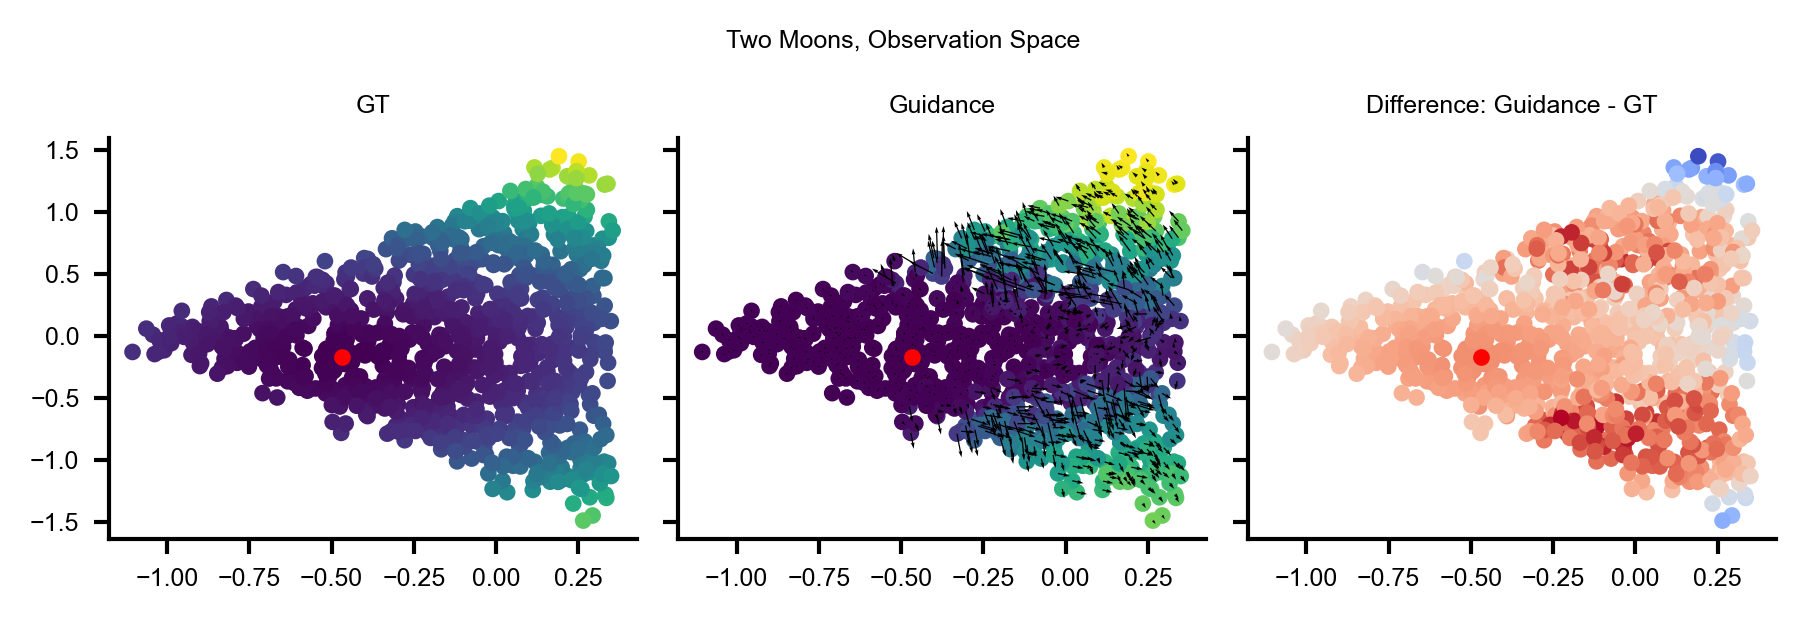

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(6, 2))

idx = 9
T = 0

time_repr = guidance.get_diff_time_repr(np.ones(len(theta)) * T)
theta = theta.detach()
theta.requires_grad = True
x = x.detach()
x.requires_grad = True
time_repr = time_repr.detach()
time_repr.requires_grad = True
pred_dist = guidance.forward(theta, x[None, [idx]].repeat(len(theta), 1, 1), time_repr)
grad = torch.autograd.grad(outputs=pred_dist.sum(), inputs=theta)[0]
theta = theta.detach()
x = x.detach()
pred_dist = pred_dist.detach()
grad = grad.detach()

ax1.scatter(*x.T, c=dist_matrix.T[idx])
ax1.scatter(*x[idx], c="r")
ax1.set_title("GT")

ax2.scatter(*x.T, c=pred_dist.squeeze())
ax2.quiver(*x.T, *grad.T)
ax2.scatter(*x[idx], c="r")                   
ax2.set_title("Guidance")

ax3.scatter(*x.T, c=pred_dist.squeeze() - dist_matrix[idx], cmap="coolwarm")
ax3.scatter(*x[idx], c="r")                   
ax3.set_title("Difference: Guidance - GT")

fig.suptitle("Two Moons, Observation Space")
fig.tight_layout()

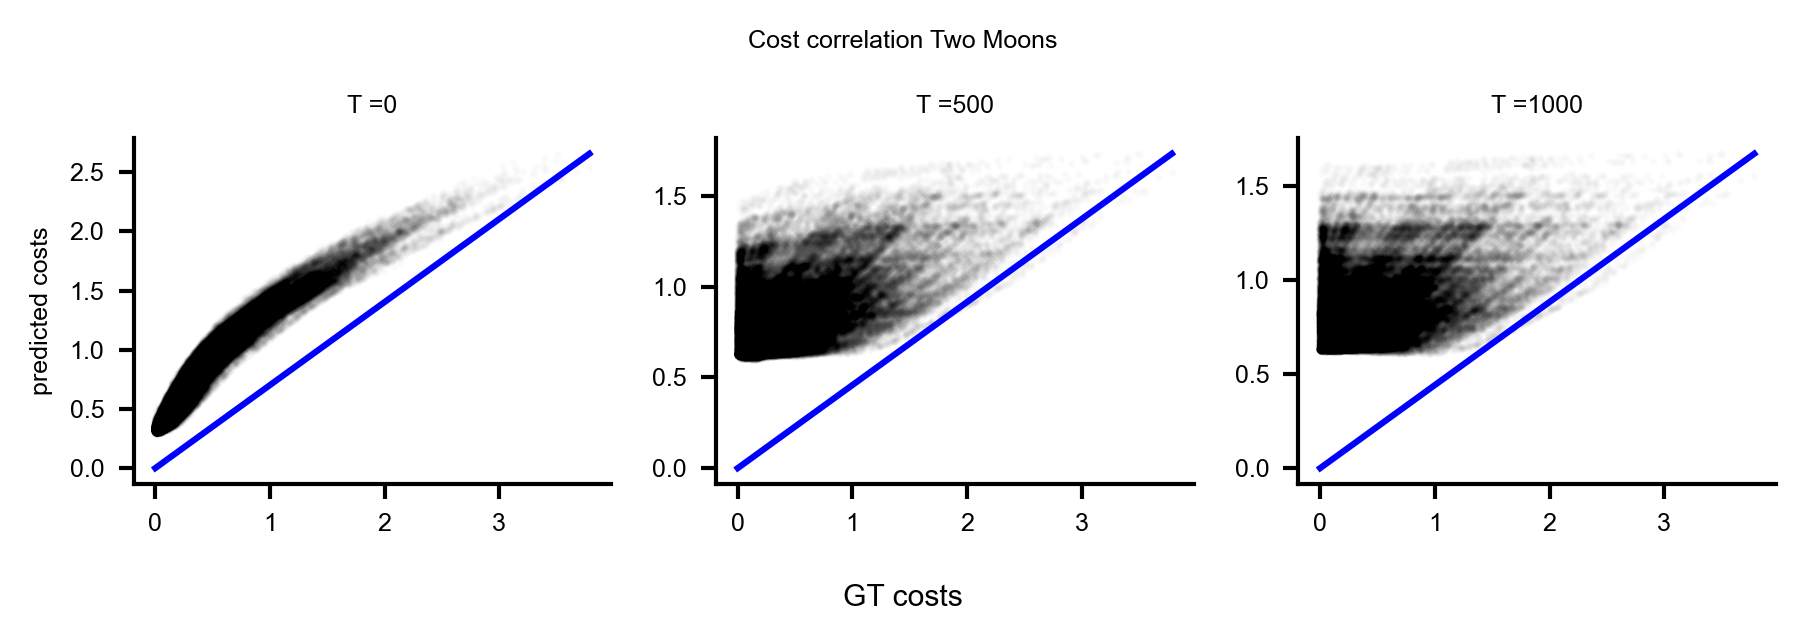

In [ ]:
indices = np.arange(100)
fig, axs = plt.subplots(ncols=3, figsize=(6, 2))


for T, ax in zip([0, 500, 1000], (axs)):
    with torch.no_grad():
        time_repr = guidance.get_diff_time_repr(np.ones(len(indices)) * T)
        pred_dist = guidance.forward(theta[[indices]], x[None].repeat(len(indices), 1, 1), time_repr)

    ax.plot([0, dist_matrix[indices].max()], [0, pred_dist.max()], color="blue")
    ax.scatter(dist_matrix[indices].flatten(), pred_dist[:, :, 0].flatten(), s=1, alpha=0.01)
    ax.set_title(f"{T =}")

axs[0].set_ylabel("predicted costs")
fig.supxlabel("GT costs")
fig.suptitle("Cost correlation Two Moons")  
fig.tight_layout()


In [ ]:
diffusion_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_diffusion/two_moons/2025-03-27-01-38-46/lightning_logs/version_0/epoch=99-step=4000.ckpt"

config: Config = Config.from_file("../config/sampling_diffusion.yaml")
sampler = DiffusionSampler(
    diffusion_ckpt, res_net_guidance_ckpt, config.observed_data_file, config.beta, False
)
#   sampler._guidance_model._net._latent_mlp = nn.Sequential(
#     sampler._guidance_model._net._latent_mlp._modules["0"],
#     sampler._guidance_model._net._latent_mlp._modules["1"],
# )

In [91]:
samples = []
gammas = [10, 100, 200, 300, 400]
n_samples = 1000
for gamma in gammas:    
    sampler.update_gamma(gamma)
    samples.append(sampler.forward(n_samples).detach())
samples = torch.stack(samples)

Sample in observed data:  80%|████████  | 8/10 [00:38<00:09,  4.85s/it]
/home/robin/projects/lab_project/neuralgbi_diffusion/gbi_diff/sampling/diffusion.py:185: SyntaxWarning: invalid escape sequence '\p'
  """


KeyboardInterrupt: 

Text(0.5, 0.98, 'Two Moons sampling Specified')

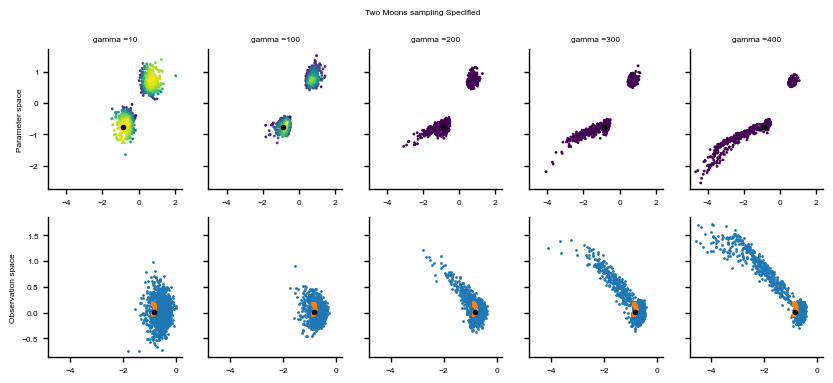

In [ ]:
x, theta = load_observed_data("../data/observed_data/two_moons_10.pt")
simulator = TwoMoonsSimulator()

fig, axs = plt.subplots(ncols=len(gammas), nrows=2, sharex="row", sharey="row", figsize=(2 * len(gammas), 4))

ax.scatter(*theta[0])
ax.scatter(*samples[:, 0].T)

sample_idx = 0
for idx, gamma in enumerate(gammas):
    axs[0, idx].scatter(*theta[sample_idx])
    time_repr = sampler._guidance_model.get_diff_time_repr(np.zeros(n_samples))
    ll = sampler._guidance_model.forward(samples[idx, :, sample_idx], x[None, [sample_idx]].repeat(n_samples, 1, 1), time_repr)
    ll = torch.exp(-gamma * ll.detach()).flatten()
    axs[0, idx].scatter(*samples[idx, :, sample_idx].T, c=ll, zorder=-1, s=1)

    axs[1, idx].scatter(*x[sample_idx])
    preds = simulator.sample(samples[idx, :, sample_idx])
    axs[1, idx].scatter(*preds.T, zorder=-1, s=1)
    gt = simulator.sample(theta[[sample_idx]].repeat(n_samples, 1))
    axs[1, idx].scatter(*gt.T, zorder=-1, s=1)
    axs[0, idx].set_title(f"{gamma =}")

axs[0, 0].set_ylabel("Parameter space")
axs[1, 0].set_ylabel("Observation space")
fig.suptitle("Two Moons sampling Specified")

Step in diffusion process: 100%|██████████| 1000/1000 [00:04<00:00, 211.74it/s]


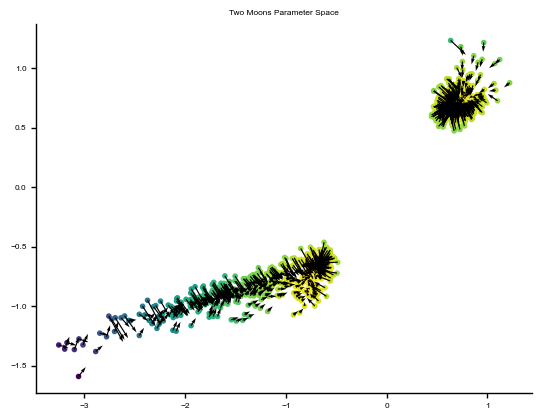

tensor([[-1.3577, -0.8647],
        [-1.0752, -0.7543],
        [-0.7116, -0.9968],
        ...,
        [-0.7539, -0.7405],
        [ 0.7756,  0.5696],
        [-1.6447, -0.8639]])

In [ ]:
def single_forward(
        sampler, x_o: Tensor, n_samples: int, quiet: bool = False
    ) -> Tensor:
    """_summary_

    Args:
        x_o (Tensor): (n_simulation_features, )
        n_samples (int): how many samples you would like to create per

    Returns:
        Tensor: (n_samples, theta_dim)
    """
    # n_samples per sample in the dataset
    theta_t = torch.normal(
        0, 1, size=(n_samples, sampler.theta_dim), requires_grad=True
    )

    T = sampler._diff_model.diffusion_steps
    T = np.arange(T)[::-1]

    if sampler._normalize_data:
        _, (x_mean, x_std) = sampler._data_stats
        x_o = (x_o - x_mean) / x_std

    iterator = T
    if not quiet:
        iterator = tqdm(T, desc="Step in diffusion process", leave=True)

    for t_idx in iterator:
        beta = sampler._diff_beta_schedule.forward(t_idx)
        alpha = sampler._diff_beta_schedule.get_alphas(t_idx)
        alpha_bar = sampler._diff_beta_schedule.get_alpha_bar(t_idx)

        time_repr = sampler._diff_model.get_diff_time_repr(np.array([t_idx]))
        time_repr = time_repr.repeat(n_samples, 1)

        diffusion_step = sampler._diff_model.forward(theta_t, time_repr)
        diffusion_step = diffusion_step.detach()
        guidance_grad = sampler.get_log_boltzmann_grad(theta_t, x_o, time_repr)
        guidance_grad = guidance_grad.detach()

        z = torch.normal(0, 1, size=theta_t.shape)
        z = torch.sqrt(beta) * z if t_idx > 0 else 0

        theta_t = (1 / torch.sqrt(alpha)) * (
            theta_t
            - (1 - alpha) / torch.sqrt(1 - alpha_bar) * diffusion_step
            + beta * guidance_grad
        ) + z

        # del diffusion_step
        # del guidance_grad
        # del time_repr

    if sampler._normalize_data:
        (theta_mean, theta_std), _ = sampler._data_stats
        theta_t = theta_t * theta_std + theta_mean

    theta_t = theta_t.detach()
    ll = sampler._guidance_model.forward(theta_t, x_o[None, None].repeat(n_samples, 1, 1), time_repr).detach()
    grad = sampler.get_log_boltzmann_grad(theta_t, x_o, time_repr).detach()
    plt.scatter(*theta_t.T.detach(), c=-ll)
    plt.quiver(theta_t[:, 0], theta_t[:, 1], *grad.T)
    plt.title("Two Moons Parameter Space")
    plt.show()


    return theta_t

sampler.update_gamma(200)
single_forward(sampler, sampler.x_o[0], 1000)